- leaky relu / elu

## Planet Kaggle competition

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

from planet import *

bs=64; f_model = resnet34
path = "data/planet/"
#torch.cuda.set_device(1)

In [10]:
!ls data/planet

test-jpg  test_v2_file_mapping.csv  train-jpg  train_v2.csv


In [3]:
n=len(list(open(f'{path}train_v2.csv')))-1

In [4]:
label_csv = f'{path}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [5]:
def get_data(sz, test_name):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(path, 'train-jpg', label_csv, tfms=tfms, 
                                       suffix='.jpg', val_idxs=val_idxs, test_name=test_name)

In [80]:
data=get_data_pad(f_model, path, 256, 64, n, 0)

In [64]:
learn = ConvLearner.pretrained(f_model, get_data(64, 'test-jpg-additional'), metrics=[f2])

### Train

In [68]:
learn.fit(0.2, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.147221   0.132121   0.882947  



[0.13212067, 0.8829468199910105]

In [69]:
learn.sched.plot_lr()

In [70]:
learn.unfreeze()

In [71]:
learn.fit([0.01,0.05,0.2], 1, cycle_len=4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.124461   0.107383   0.908111  
    1      0.110126   0.101128   0.914976                    
    2      0.105942   0.098216   0.918434                    
    3      0.100777   0.097792   0.917562                     



[0.09779161, 0.9175617878302365]

In [72]:
learn.fit([1e-4,1e-3,0.01], 4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.103083   0.096997   0.919712  
    1      0.103639   0.096832   0.919074                     
    2      0.100372   0.096749   0.918764                     
    3      0.100983   0.096926   0.918938                     



[0.096926324, 0.9189376580079353]

### Evaluate

In [73]:
learn.save('planet')

In [74]:
learn.load('planet')

FileNotFoundError: [Errno 2] No such file or directory: 'data/planet/models/170809_0_cyc_1.h5'

In [75]:
val = learn.predict()

In [76]:
f2(val,data.val_y)

0.9153293586050979

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

0.93020923622107132

In [77]:

log_preds_partial= learn.predict(is_test=True)


In [78]:
log_preds_partial.shape

(20522, 17)

['artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'haze', 'partly_cloudy', 'road', 'selective_logging', 'slash_burn', 'water']


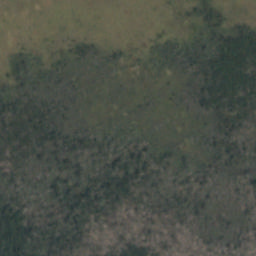

In [59]:
def get_labels(a): return [data.classes[o] for o in a.nonzero()[0]]

lbls = log_preds_partial>0.3
idx=3
print(get_labels(lbls[idx]))
PIL.Image.open(path+data.test_dl.dataset.fnames[idx]).convert('RGB')

In [81]:
res = [get_labels(o) for o in lbls]
learn.data.test_dl.dataset.fnames[:5]


['test-jpg/test_20868.jpg',
 'test-jpg/test_14326.jpg',
 'test-jpg/test_7125.jpg',
 'test-jpg/test_8361.jpg',
 'test-jpg/test_22414.jpg']

['test-jpg-additional/file_14952.jpg',
 'test-jpg-additional/file_6424.jpg',
 'test-jpg-additional/file_15217.jpg',
 'test-jpg-additional/file_15544.jpg',
 'test-jpg-additional/file_4523.jpg']

In [86]:
outp = pd.DataFrame({'image_name': [f[25:-4] for f in learn.data.test_dl.dataset.fnames],
        'tags': [' '.join(l) for l in res]})
outp.head()

,image_name,tags
0,14952,agriculture artisinal_mine bare_ground blow_do...
1,6424,agriculture artisinal_mine bare_ground bloomin...
2,15217,artisinal_mine bare_ground blooming blow_down ...
3,15544,artisinal_mine bare_ground blooming blow_down ...
4,4523,agriculture artisinal_mine bare_ground bloomin...


In [90]:
outp.to_csv('subm2.gz', compression='gzip', index=None)

In [91]:
from IPython.display import FileLink

In [92]:
FileLink('subm2.gz')

/home/vaibhavnandwani/fastai/courses/dl1/subm2.gz

In [47]:
def cycle_preds(name, cycle, n_tta=4, is_test=False):
    learn.load_cycle(name, cycle)
    return learn.TTA(n_tta, is_test=is_test)

def cycle_cv_preds(cv, n_tta=4, is_test=False):
    data=get_data_pad(f_model, path, 256, 64, n, cv)
    learn.set_data(data)
    return [cycle_preds(f'{name}_{cv}',i, is_test=is_test) for i in range(5)]

- check dogs and cats
- get resize working again with new path structure

In [48]:
%%time
preds_arr=[]
for i in range(5):
    print(i)
    preds_arr.append(cycle_cv_preds(i, is_test=True))

0


NameError: name 'name' is not defined

In [41]:
def all_cycle_cv_preds(end_cycle, start_cycle=0, n_tta=4, is_test=False):
    return [cycle_cv_preds(i, is_test=is_test) for i in range(start_cycle, end_cycle)]

In [11]:
np.savez_compressed(f'{path}tmp/test_preds', preds_arr)

In [20]:
preds_avg = [np.mean(o,0) for o in preds_arr]
test = np.mean(preds_avg,0)

In [42]:
%time preds_arr = all_cycle_cv_preds(5)

CPU times: user 54min 11s, sys: 2min 40s, total: 56min 52s
Wall time: 56min 18s


In [55]:
[f2(preds_arr[0][o],data.val_y) for o in range(5)]

[0.93071536605914396,
 0.93116843932677196,
 0.93069579784787815,
 0.9307239826054069,
 0.93051232753450475]

In [44]:
preds_avg = [np.mean(o,0) for o in preds_arr]

In [45]:
ys = [get_data_zoom(f_model, path, 256, 64, n, cv).val_y for cv in range(5)]

In [54]:
f2s = [f2(o,y) for o,y in zip(preds_avg,ys)]; f2s

[0.93137364725177285,
 0.93053278668158479,
 0.93297669347979839,
 0.9323465548921448,
 0.93621843040962094]

In [49]:
ots = [opt_th(o,y) for o,y in zip(preds_avg,ys)]; ots

[0.20000000000000004,
 0.17000000000000001,
 0.21000000000000005,
 0.23000000000000007,
 0.19000000000000003]

In [50]:
np.mean(ots)

0.20000000000000004

In [53]:
np.mean(f2s,0)

0.93268962254298438

### End